In [ ]:
from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
import pandas as pd
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns

In [ ]:
start_date = datetime.strptime('2018-08-31', "%Y-%m-%d")
end_date = datetime.strptime('2023-08-21', "%Y-%m-%d")

df = yf.download("AMAT", start=start_date, end=end_date)

df.reset_index(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['50_day_ma'] = df['Close'].rolling(window=50).mean()
df['1000_day_ma'] = df['Close'].rolling(window=1000).mean()
df['10_day_vol_avg'] = df['Volume'].rolling(window=10).mean()
df['200_day_vol_avg'] = df['Volume'].rolling(window=200).mean()

df = df[['Date', 'Close']]

df.to_csv('AMAToutput.csv', index=False)

print(df)

[*********************100%%**********************]  1 of 1 completed
           Date       Close
0    2018-08-31   43.020000
1    2018-09-04   42.619999
2    2018-09-05   42.500000
3    2018-09-06   40.270000
4    2018-09-07   39.849998
...         ...         ...
1244 2023-08-14  141.889999
1245 2023-08-15  140.080002
1246 2023-08-16  138.250000
1247 2023-08-17  137.589996
1248 2023-08-18  142.660004

[1249 rows x 2 columns]


In [ ]:
df.set_index('Date', inplace=True)

df.dropna(inplace=True)

train_df = df.sort_values(by=['Date']).copy()

#FEATURES = ['Close', '50_day_ma', '200_day_ma']
FEATURES = ['Close']

print('FEATURE LIST')
print([f for f in FEATURES])

print(df)

data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

data_filtered_ext.tail()

nrows = data_filtered.shape[0]

np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

FEATURE LIST
['Close']
                 Close
Date                  
2018-08-31   43.020000
2018-09-04   42.619999
2018-09-05   42.500000
2018-09-06   40.270000
2018-09-07   39.849998
...                ...
2023-08-14  141.889999
2023-08-15  140.080002
2023-08-16  138.250000
2023-08-17  137.589996
2023-08-18  142.660004

[1249 rows x 1 columns]
(1249, 1)


<ipython-input-316-ec3b8b1128a6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
sequence_length = 100

index_Close = data_filtered.columns.get_loc("Close")

train_data_len = math.ceil(np_data_scaled.shape[0] * 0.6)

train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

In [ ]:
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    print(index_Close)
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:])
        y.append(data[i, index_Close])

    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

0
0
(650, 100, 1) (650,)
(499, 100, 1) (499,)
0.07035722756117527
0.07035722756117527
100 100 1


In [ ]:
model.compile(optimizer='adam', loss='mse')

epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience = 3, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=[])

Epoch 1/10
41/41 [==============================] - 7s 46ms/step - loss: 0.0121 - val_loss: 0.0037
Epoch 2/10
41/41 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 3/10
41/41 [==============================] - 1s 15ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 4/10
41/41 [==============================] - 1s 15ms/step - loss: 9.5271e-04 - val_loss: 0.0020
Epoch 5/10
41/41 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 6/10
41/41 [==============================] - 1s 15ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 7/10
41/41 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 8/10
41/41 [==============================] - 1s 15ms/step - loss: 9.2109e-04 - val_loss: 0.0022
Epoch 9/10
41/41 [==============================] - 1s 14ms/step - loss: 8.0477e-04 - val_loss: 0.0020
Epoch 10/10
41/41 [==============================] - 1s 15ms/step - loss: 7.4151e-04 - val_loss: 

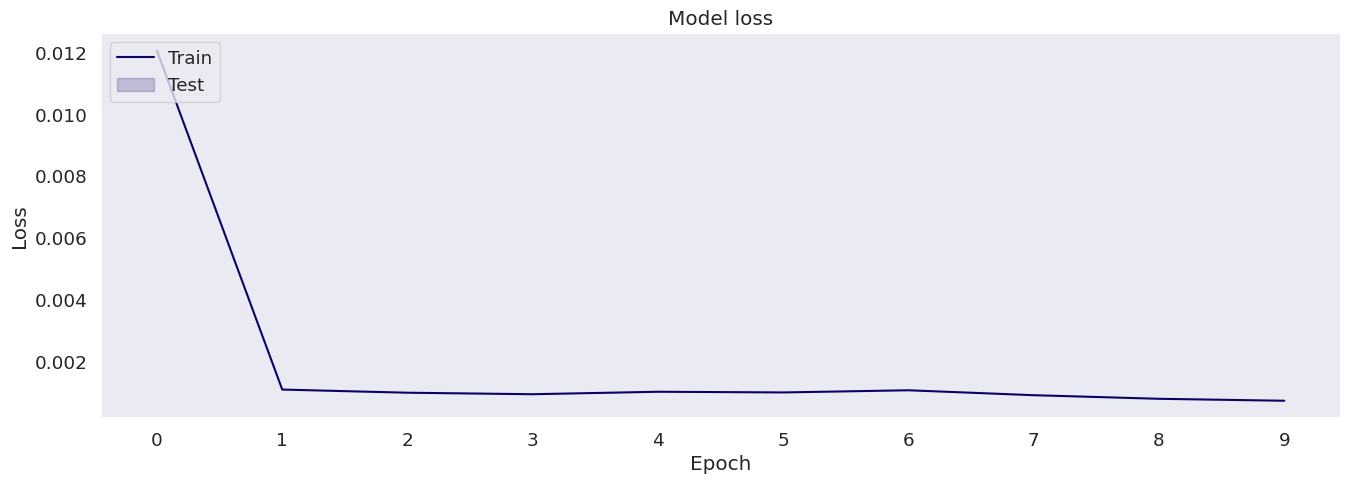

In [ ]:
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

16/16 [==============================] - 1s 7ms/step
Accuracy: 0.466 %
Precision: 0.467 %
Recall: 0.49 %
F Score: 0.478 %


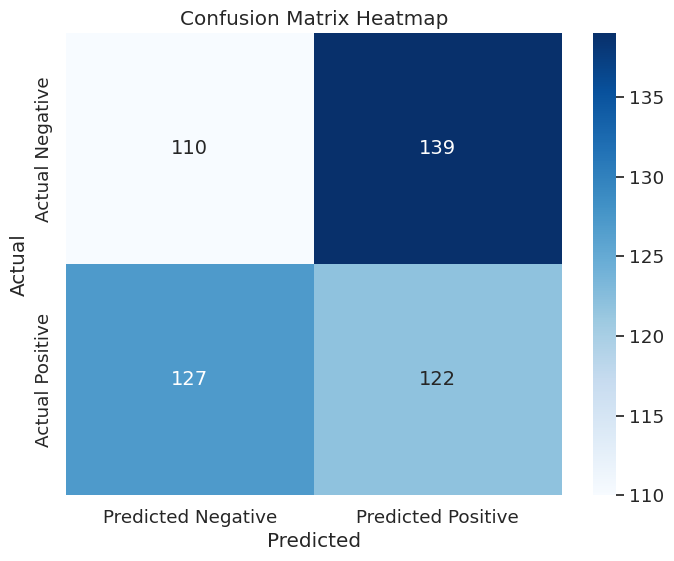

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_scaled = model.predict(x_test)

y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

y_pred_bin = []
y_test_bin = []

for i in range(1, len(y_pred)):
    if (y_pred[i] > y_pred[i-1]):
      y_pred_bin.append(1)
    else:
      y_pred_bin.append(-1)

for i in range(1, len(y_test_unscaled)):
    if (y_test_unscaled[i] > y_test_unscaled[i-1]):
      y_test_bin.append(1)
    else:
      y_test_bin.append(-1)

count_up = 0
count_down = 0
total_up = 0
total_down = 0
for i in range(len(y_pred_bin)):
  if (y_pred_bin[i] == y_test_bin[i]):
    if (y_pred_bin[i] == 1):
      count_up += 1
    else:
      count_down += 1
  if (y_test_bin[i] == 1):
    total_up += 1
  else:
    total_down += 1

accuracy = (count_up + count_down)/(total_up + total_down)
precision = count_up/(count_up + total_down - count_down)
recall = count_up/(total_up)
f_score = 2 * (precision*recall)/(precision + recall)

print(f'Accuracy: {np.round(accuracy, 3)} %')
print(f'Precision: {np.round(precision, 3)} %')
print(f'Recall: {np.round(recall, 3)} %')
print(f'F Score: {np.round(f_score, 3)} %')

cm = confusion_matrix(y_test_bin, y_pred_bin)

# Create a heatmap of the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14}, cbar=True,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()

DatetimeIndex(['2018-08-31', '2018-09-04', '2018-09-05', '2018-09-06',
               '2018-09-07', '2018-09-10', '2018-09-11', '2018-09-12',
               '2018-09-13', '2018-09-14',
               ...
               '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10',
               '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18'],
              dtype='datetime64[ns]', name='Date', length=1250, freq=None)


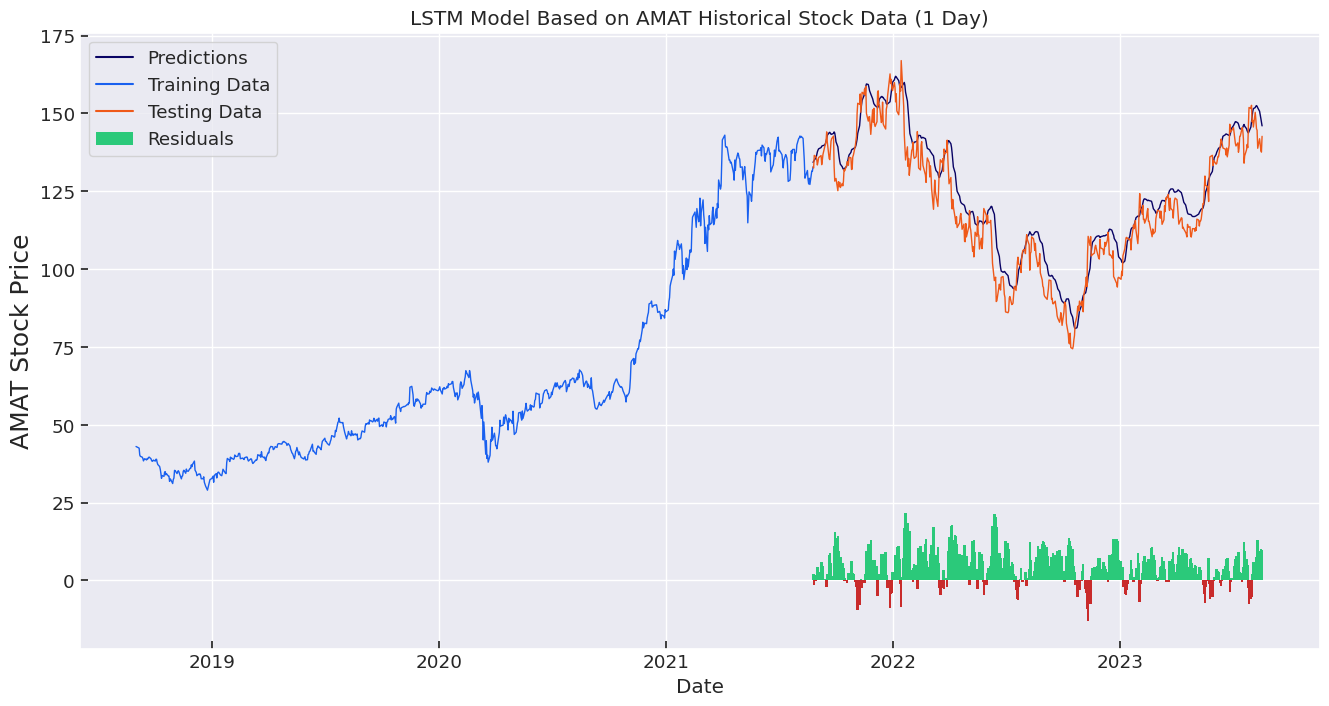

In [ ]:
display_start_date = "2010-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['2018-08-31', '2018-09-04', '2018-09-05', '2018-09-06',
               '2018-09-07', '2018-09-10', '2018-09-11', '2018-09-12',
               '2018-09-13', '2018-09-14',
               ...
               '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10',
               '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18'],
              dtype='datetime64[ns]', name='Date', length=1250, freq=None)


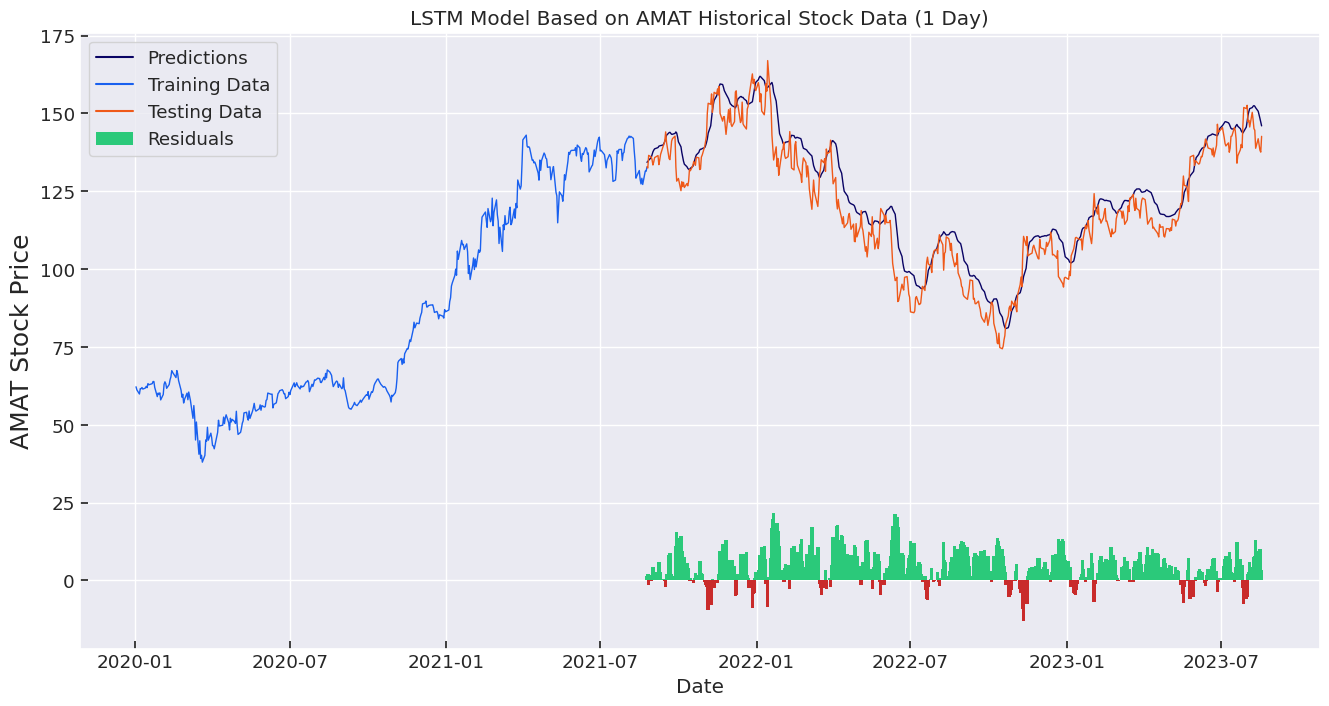

In [ ]:
display_start_date = "2020-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

DatetimeIndex(['2018-08-31', '2018-09-04', '2018-09-05', '2018-09-06',
               '2018-09-07', '2018-09-10', '2018-09-11', '2018-09-12',
               '2018-09-13', '2018-09-14',
               ...
               '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10',
               '2023-08-11', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-17', '2023-08-18'],
              dtype='datetime64[ns]', name='Date', length=1250, freq=None)


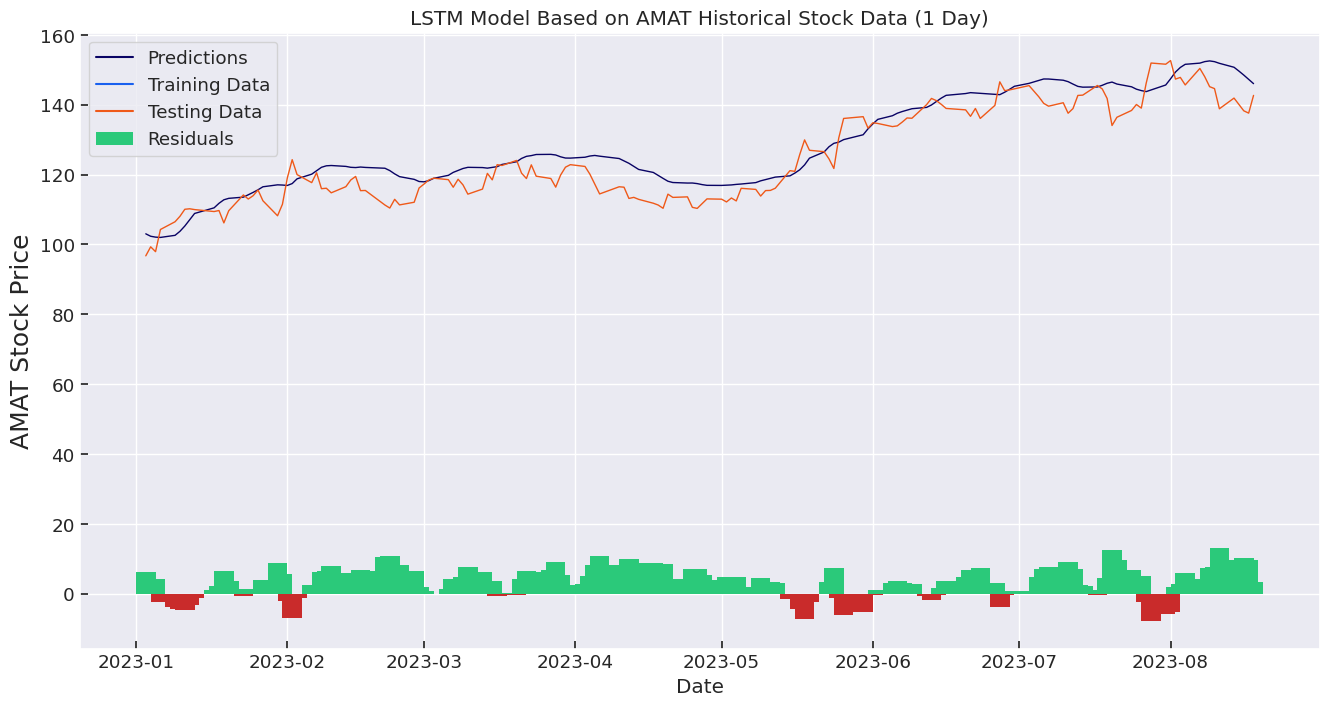

In [ ]:
display_start_date = "2023-01-01"

train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'Training Data'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'Testing Data'})
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Residuals", valid["Predictions"] - valid["Testing Data"], True)
df_union = pd.concat([train, valid])

print(df_union.index)

df_union_zoom = df_union[df_union.index > display_start_date]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("LSTM Model Based on AMAT Historical Stock Data (1 Day)")
plt.ylabel("AMAT Stock Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['Predictions', 'Training Data', 'Testing Data']], linewidth=1.0, dashes=False, ax=ax1)

df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["Residuals"].dropna()]
ax1.bar(height=df_union_zoom['Residuals'].dropna(), x=df_union_zoom['Residuals'].dropna().index, width=4, label='Residuals', color=df_sub, edgecolor='none')
ax1.tick_params(which='both', direction='in', bottom=True, left=True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
plt.legend()
plt.show()

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

X_test_new = []
X_test_new.append(last_N_days_scaled)

pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''

print(f'The close price for {"AMAT"} at {str(dt.date.today())} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


1/1 [==============================] - 0s 30ms/step
The close price for AMAT at 2023-08-23 was 142.66
The predicted close price is 145.4199981689453 (+1.9%)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Make predictions
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# Inverse transform predictions
train_predict = scaler_pred.inverse_transform(train_predict)
y_train = scaler_pred.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler_pred.inverse_transform(test_predict)
y_test = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mae_train = mean_absolute_error(y_train, train_predict)
mse_train = mean_squared_error(y_train, train_predict)
rmse_train = np.sqrt(mse_train)

mae_test = mean_absolute_error(y_test, test_predict)
mse_test = mean_squared_error(y_test, test_predict)
rmse_test = np.sqrt(mse_test)

print(f'Training MAE: {mae_train:.4f}')
print(f'Training MSE: {mse_train:.4f}')
print(f'Training RMSE: {rmse_train:.4f}')
print(f'Testing MAE: {mae_test:.4f}')
print(f'Testing MSE: {mse_test:.4f}')
print(f'Testing RMSE: {rmse_test:.4f}')

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

mape = calculate_mape(y_test, test_predict)
print(f'Mean Absolute Percentage Error: {mape:.4f}')

r2 = r2_score(y_test, test_predict)
print(f"R-squared (R2): {r2:.4f}")

0
0
16/16 [==============================] - 0s 6ms/step
Training MAE: 3.0093
Training MSE: 17.9714
Training RMSE: 4.2393
Testing MAE: 5.6104
Testing MSE: 49.4245
Testing RMSE: 7.0303
Mean Absolute Percentage Error: 4.9243
R-squared (R2): 0.8822
